# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [217]:
import numpy as np
from glob import glob
import random
import cv2                
import os
from pathlib import Path
from tqdm import tqdm
import torchvision
from torchvision import datasets
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from PIL import ImageFile
from PIL import Image
import IPython
import matplotlib.pyplot as plt
%matplotlib inline     

In [218]:
random.seed(8675307)

path = "C:\deep-learning-v2-pytorch-master\project-dog-classification"
# load filenames for human and dog images
human_files = np.array(glob(path + "\images\lfw~\*\*\*"))
dog_files = np.array(glob(path + "\images\dogImages\*\*\*"))

random.shuffle(human_files)
random.shuffle(dog_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))


There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


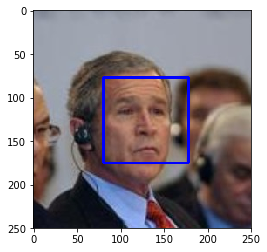

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(path + '/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [244]:
# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_file = [face_detector(file) for file in human_files_short]
dog_file = [face_detector(file) for file in dog_files_short]

human_percentage = human_file.count(True) / len(human_file) * 100
human_in_dog_percentange = dog_file.count(True) / len(dog_file) * 100

print("Human faces detected in human file: {}%".format(human_percentage))
print("Human faces detected in dog file: {}%".format(human_in_dog_percentange))

There are 13233 total human images.
Human faces detected in human file: 97.0%
Human faces detected in dog file: 11.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [233]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

MEANS = [0.485, 0.456, 0.406]
DEVIATIONS = [0.229, 0.224, 0.225]

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()])
    img = in_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img)
    index = torch.max(ret,1)[1].item()
    return index

filename = '/images/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
imgFile = path + filename

print("Index:",VGG16_predict(imgFile))

Index: 252


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [227]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function. 
    pred = VGG16_predict(img_path)
    return (pred <= 268) and (pred >= 151)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  Using the VGG16 model I got 0% with human files short.
             93% with dog files short.

In [232]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def test_shortFile():
    human_dogs = [dog_detector(i) for i in human_files_short]
    dogs = [dog_detector(j) for j in dog_files_short]
    
    human = str(float(sum(human_dogs)) / len(human_files_short) * 100)
    dog = str(float(sum(dogs)) / len(dog_files_short) * 100)
    
    print('percent of dogs detected in human images:',human)
    print('percent of dogs detected in dog images:',dog)

test_shortFile()

percent of dogs detected in human images: 0.0
percent of dogs detected in dog images: 93.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [234]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
newpath = Path(path + "\images\dogImages").expanduser()
train_path = newpath.joinpath("train")
valid_path = newpath.joinpath("valid")
test_path = newpath.joinpath("test")

IMAGE_SIZE = 224

MEANS = [0.485, 0.456, 0.406]
DEVIATIONS = [0.229, 0.224, 0.225] 

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.Resize(IMAGE_SIZE),
                                      transforms.CenterCrop(IMAGE_SIZE),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=MEANS,std=DEVIATIONS)])

test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                     transforms.CenterCrop(IMAGE_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEANS,std=DEVIATIONS)])

training = datasets.ImageFolder(root=str(train_path),transform=train_transform)
validation = datasets.ImageFolder(root=str(valid_path),transform=test_transform)
testing = datasets.ImageFolder(root=str(test_path),transform=test_transform)

batch = 32
workers = 0

train_batches = torch.utils.data.DataLoader(training,
                                            batch_size=batch,
                                            shuffle=True,
                                            num_workers=workers)

valid_batches = torch.utils.data.DataLoader(validation,
                                            batch_size=batch,
                                            shuffle=True, 
                                            num_workers=workers)

test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=batch,
                                           shuffle=True,
                                           num_workers=workers)

loaders_scratch = dict(train=train_batches,
                       valid=valid_batches,
                       test=test_batches)
                     

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:I resized the image with transform resizer for testing now it's 224.  The center crop is 224 and then I normalized it. I augmented the data using random rotation of 30, vertical and horizontal flip.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
# define the CNN architecture
L1_IN = 3
L1_OUT = 16
L2_OUT = L1_OUT * 2
L3_OUT = L2_OUT * 2
FLATTEN = L3_OUT*28*28
FC = 500
BREEDS = len(training.classes)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
              # wxh remains same with this padding
        self.conv1 = nn.Conv2d(L1_IN,L1_OUT,3,padding=1) #3,16
        self.conv2 = nn.Conv2d(L1_OUT,L2_OUT,3,padding=1) #16,32
        self.conv3 = nn.Conv2d(L2_OUT,L3_OUT,3,padding=1) #32,64
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(FLATTEN, 500)
        self.fc2 = nn.Linear(500, BREEDS)
        
        self.dropout = nn.Dropout(0.2)
        
        self.batch_norm = nn.BatchNorm1d(FC)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image
        x = x.view(x.size(0), -1)
        # dropout layer
        x = self.dropout(x)
        # activation for first layer
        x = self.dropout(F.relu(self.batch_norm(self.fc1(x))))
        return self.fc2(x)

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
    The first conv layer it starts at 3, then for the second layer 16, and followed by 32.  Max depth is 64. For the kernel size I picked 3 with a stride of 1.  20% dropout of neurons for each iteration wouldn't overfit. I chose to use the relu activation function because of it's simplicity and also it converges faster than most other activations. Relu turns negative values to zero.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
### TODO: select loss function
crit_scratch = nn.CrossEntropyLoss()

optim_scratch = optimizer.SGD(model_scratch.parameters(),lr=0.001,momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
# the following import is required for training to be robust to truncated images

# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

epochs = 50

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    print("Started Training...")
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            with torch.no_grad():
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
    
    # return trained model
    print("Finished training")
    
    return model

model = model_scratch
model_path = Path("~/deep-learning-v2-pytorch/models/dog-breed-classification/").expanduser()
save_path = model_path.joinpath("model_scratch.pt")

# train the model
model_scratch = train(epochs, loaders_scratch, model, optim_scratch, crit_scratch, use_cuda, save_path)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(save_path))

Started Training...
Epoch: 1 	Training Loss: 4.796432 	Validation Loss: 4.668242
Validation loss decreased (inf --> 4.668242).  Saving model ...
Epoch: 2 	Training Loss: 4.585992 	Validation Loss: 4.545935
Validation loss decreased (4.668242 --> 4.545935).  Saving model ...
Epoch: 3 	Training Loss: 4.454954 	Validation Loss: 4.472860
Validation loss decreased (4.545935 --> 4.472860).  Saving model ...
Epoch: 4 	Training Loss: 4.356812 	Validation Loss: 4.405796
Validation loss decreased (4.472860 --> 4.405796).  Saving model ...
Epoch: 5 	Training Loss: 4.276275 	Validation Loss: 4.300752
Validation loss decreased (4.405796 --> 4.300752).  Saving model ...
Epoch: 6 	Training Loss: 4.205637 	Validation Loss: 4.265211
Validation loss decreased (4.300752 --> 4.265211).  Saving model ...
Epoch: 7 	Training Loss: 4.140741 	Validation Loss: 4.195077
Validation loss decreased (4.265211 --> 4.195077).  Saving model ...
Epoch: 8 	Training Loss: 4.071529 	Validation Loss: 4.133655
Validation los

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model, crit_scratch, use_cuda)

Test Loss: 3.457355


Test Accuracy: 18% (157/836)


In [213]:
# train the model some more
epochs = 25
model_scratch = train(epochs, loaders_scratch, model, optim_scratch, crit_scratch, use_cuda, save_path)
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(save_path))

Started Training...
Epoch: 1 	Training Loss: 1.490623 	Validation Loss: 3.453214
Validation loss decreased (inf --> 3.453214).  Saving model ...
Epoch: 2 	Training Loss: 1.449845 	Validation Loss: 3.526742
Epoch: 3 	Training Loss: 1.429861 	Validation Loss: 3.410142
Validation loss decreased (3.453214 --> 3.410142).  Saving model ...
Epoch: 4 	Training Loss: 1.365082 	Validation Loss: 3.522943
Epoch: 5 	Training Loss: 1.353661 	Validation Loss: 3.446286
Epoch: 6 	Training Loss: 1.344284 	Validation Loss: 3.587307
Epoch: 7 	Training Loss: 1.296096 	Validation Loss: 3.404260
Validation loss decreased (3.410142 --> 3.404260).  Saving model ...
Epoch: 8 	Training Loss: 1.279469 	Validation Loss: 3.479128
Epoch: 9 	Training Loss: 1.237547 	Validation Loss: 3.633113
Epoch: 10 	Training Loss: 1.232511 	Validation Loss: 3.529833
Epoch: 11 	Training Loss: 1.177139 	Validation Loss: 3.688969
Epoch: 12 	Training Loss: 1.169709 	Validation Loss: 3.624178
Epoch: 13 	Training Loss: 1.148232 	Validat

In [219]:
# call test function again   
test(loaders_scratch, model, crit_scratch, use_cuda)

Test Loss: 3.529214


Test Accuracy: 19% (165/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
model_transfer = models.resnet50(pretrained=True)
classifierInputs = model_transfer.fc.in_features

print(classifierInputs)

2048


In [28]:
## TODO: Specify model architecture 
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(in_features=classifierInputs,
                              out_features=BREEDS,
                              bias=True)

fc_parameters = model_transfer.fc.parameters()
for param in fc_parameters:
    param.requires_grad = True
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transfer.to(device)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Resnet50 is what I picked for transfer learning because the architecture has a way to skip one or more layers to prevent overfitting.  It is excellent at image classification better then Inception and VGG16/19.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optimizer.Adam(model_transfer.parameters(),lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
epochs = 20
save_transfer = model_path.joinpath('model_transfer.pt')
# train the model
model_transfer = train(epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, save_transfer)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(save_transfer))

Started Training...
Epoch: 1 	Training Loss: 3.046199 	Validation Loss: 1.139004
Validation loss decreased (inf --> 1.139004).  Saving model ...
Epoch: 2 	Training Loss: 1.540362 	Validation Loss: 0.774685
Validation loss decreased (1.139004 --> 0.774685).  Saving model ...
Epoch: 3 	Training Loss: 1.251613 	Validation Loss: 0.616813
Validation loss decreased (0.774685 --> 0.616813).  Saving model ...
Epoch: 4 	Training Loss: 1.082750 	Validation Loss: 0.622940
Epoch: 5 	Training Loss: 0.984092 	Validation Loss: 0.559676
Validation loss decreased (0.616813 --> 0.559676).  Saving model ...
Epoch: 6 	Training Loss: 0.900339 	Validation Loss: 0.599519
Epoch: 7 	Training Loss: 0.830008 	Validation Loss: 0.501751
Validation loss decreased (0.559676 --> 0.501751).  Saving model ...
Epoch: 8 	Training Loss: 0.839280 	Validation Loss: 0.495391
Validation loss decreased (0.501751 --> 0.495391).  Saving model ...
Epoch: 9 	Training Loss: 0.764717 	Validation Loss: 0.524086
Epoch: 10 	Training Lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.554671


Test Accuracy: 82% (692/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [32]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
loaders_transfer['train'].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [73]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

image_file_name: .\images\samples\American_water_spaniel_00648.jpg, 	 predition breed: Boykin spaniel


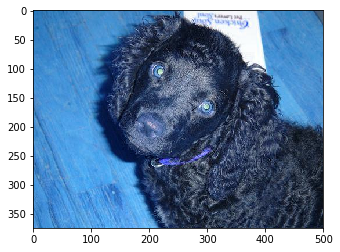

image_file_name: .\images\samples\Brittany_02625.jpg, 	 predition breed: Brittany


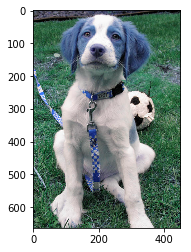

image_file_name: .\images\samples\Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever


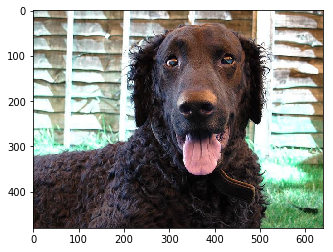

image_file_name: .\images\samples\Labrador_retriever_06449.jpg, 	 predition breed: Labrador retriever


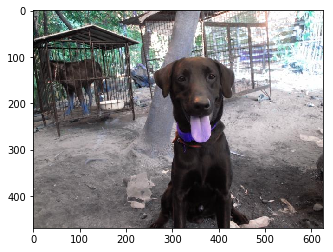

image_file_name: .\images\samples\Labrador_retriever_06455.jpg, 	 predition breed: Labrador retriever


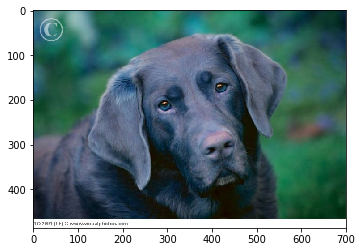

image_file_name: .\images\samples\Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever


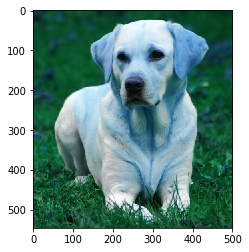

image_file_name: .\images\samples\sample_cnn.png, 	 predition breed: Affenpinscher


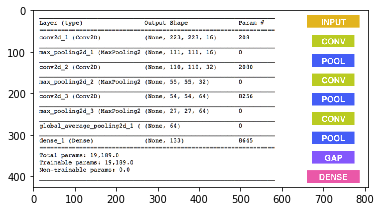

image_file_name: .\images\samples\sample_dog_output.png, 	 predition breed: American staffordshire terrier


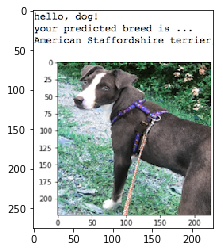

image_file_name: .\images\samples\sample_human_output.png, 	 predition breed: Brussels griffon


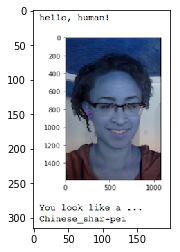

image_file_name: .\images\samples\Welsh_springer_spaniel_08203.jpg, 	 predition breed: Irish red and white setter


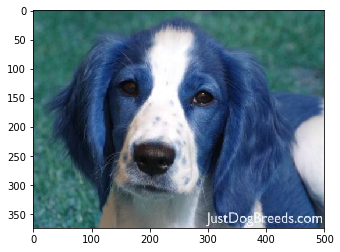

In [198]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    images = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=MEANS,std=DEVIATIONS)])
    img = prediction_transform(images)[:3,:,:].unsqueeze(0)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

dirs = os.listdir('.\images\samples')

for img_file in dirs:
    img_path = os.path.join('.\images\samples', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [230]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(model_transfer,class_names,img_path)
        print("Dog Detected \n It looks like a {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(model_transfer,class_names,img_path)
        print("Human detected \n It looks like a {0}".format(prediction))
    else:
        print("Nothing detected")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ (Three possible points for improvement)For starters I could run training for a little longer to get better results. Secondly by adding more layers to nn.  Lastly more data will increase accuracy.  The output predicted my cat as nothing which is pretty good I thought it might predict a dog from it. It detected me correctly as human looking like a pointer dog.

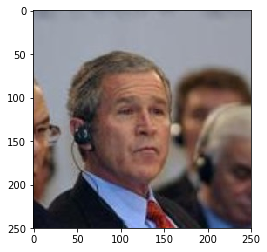

Human detected 
 It looks like a Dachshund


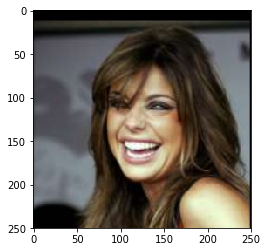

Human detected 
 It looks like a Bearded collie


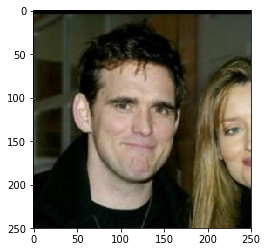

Human detected 
 It looks like a Pharaoh hound


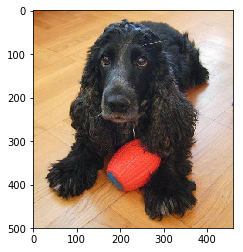

Dog Detected 
 It looks like a English cocker spaniel


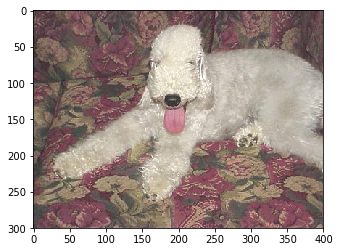

Nothing detected


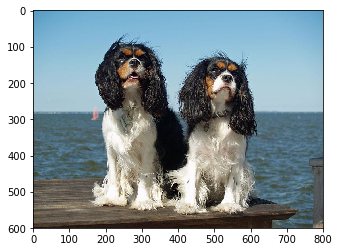

Dog Detected 
 It looks like a Cavalier king charles spaniel


In [231]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)    

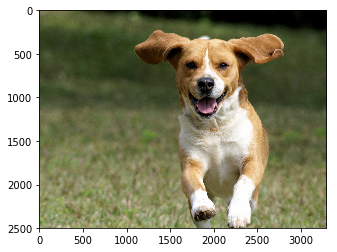

Dog Detected 
 It looks like a Pointer


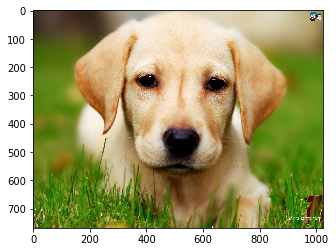

Dog Detected 
 It looks like a Labrador retriever


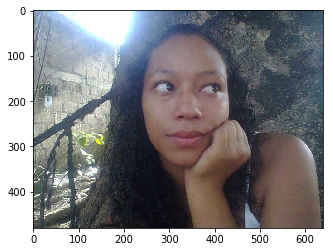

Human detected 
 It looks like a Pharaoh hound


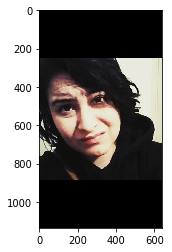

Human detected 
 It looks like a Portuguese water dog


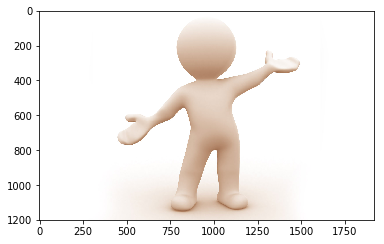

Nothing detected


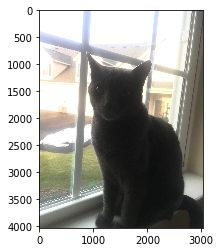

Nothing detected


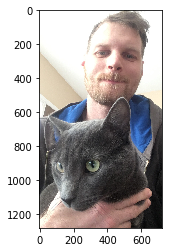

Human detected 
 It looks like a Pointer


In [247]:
mypath = 'C:/deep-learning-v2-pytorch-master/project-dog-classification/myImg/'
images = ['dog1.jpg','dogs2.jpg','exgf3.jpg','exgf4.png','humish.jpg','shadow_cat.jpg','me.jpg'] 

for file in images:
    myimg = mypath + file
    run_app(myimg)
    